In [12]:
# !pip3 install pyswarms

In [2]:
import os

import absl.logging

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set ABSL logging to ERROR to suppress warnings (only show errors)
absl.logging.set_verbosity(absl.logging.ERROR)

In [3]:
# Necessary imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:

# Load the dataset
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)

data.head()


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# Separating features and target
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

# Encoding target variable: Malignant (M) as 1, Benign (B) as 0
y = np.where(y == "M", 1, 0)

# Split the dataset to keep aside 100 samples from each class for testing
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

X_class_0 = X[class_0_indices]
X_class_1 = X[class_1_indices]
y_class_0 = y[class_0_indices]
y_class_1 = y[class_1_indices]

# Separate 100 samples from each class for the test set
X_test_class_0, X_train_class_0 = X_class_0[:100], X_class_0[100:]
X_test_class_1, X_train_class_1 = X_class_1[:100], X_class_1[100:]
y_test_class_0, y_train_class_0 = y_class_0[:100], y_class_0[100:]
y_test_class_1, y_train_class_1 = y_class_1[:100], y_class_1[100:]

# Combine the class-separated training and test sets
X_train = np.concatenate((X_train_class_0, X_train_class_1))
y_train = np.concatenate((y_train_class_0, y_train_class_1))
X_test_small = np.concatenate((X_test_class_0, X_test_class_1))
y_test_small = np.concatenate((y_test_class_0, y_test_class_1))



In [6]:

np.random.seed(42)

# Determine the number of samples in the minority class
minority_class_size = min(len(X_train_class_0), len(X_train_class_1))

# Calculate the number of samples to duplicate from the majority class
majority_class_size = 3 * minority_class_size - len(X_train_class_1)

# Randomly select samples to duplicate from the majority class
indices_to_duplicate = np.random.choice(len(X_train_class_1), majority_class_size, replace=True)

# Extract the samples to be duplicated
X_to_duplicate = X_train_class_1[indices_to_duplicate]
y_to_duplicate = y_train_class_1[indices_to_duplicate]

# Add noise to the duplicated samples
noise_factor = 0.01
noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_to_duplicate.shape)
X_to_duplicate_noisy = X_to_duplicate + noise

# Combine the original training data with the noisy duplicates
X_train_imbalanced = np.vstack((X_train, X_to_duplicate_noisy))
y_train_imbalanced = np.hstack((y_train, y_to_duplicate))





In [7]:
# Calculate the number of labels to flip for each class
num_to_flip_class_0 = int(0.05 * len(y_train_imbalanced[y_train_imbalanced == 0]))
num_to_flip_class_1 = int(0.05 * len(y_train_imbalanced[y_train_imbalanced == 1]))

# Randomly choose the indices of labels to flip
indices_to_flip_class_0 = np.random.choice(np.where(y_train_imbalanced == 0)[0], num_to_flip_class_0, replace=False)
indices_to_flip_class_1 = np.random.choice(np.where(y_train_imbalanced == 1)[0], num_to_flip_class_1, replace=False)

# Flip the labels
y_train_imbalanced[indices_to_flip_class_0] = 1
y_train_imbalanced[indices_to_flip_class_1] = 0

print(X_train_imbalanced.shape[1])
print(y_train_imbalanced.shape[0])

print(X_test_small.shape[1])
print(y_test_small.shape[0])


30
593
30
200


In [8]:

# Determine the number of input features (number of columns in X_train_imbalanced)
input_dim = X_train_imbalanced.shape[1]
print(input_dim)

# Create the neural network model with one hidden layer of size twice the number of input features
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and the ADAM optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


30


7/7 [==============================] - 0s 302us/step


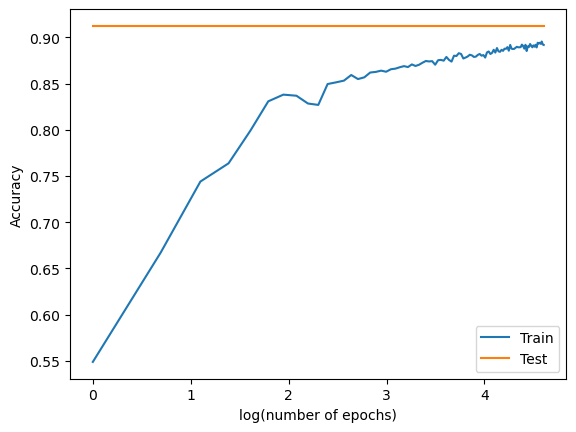

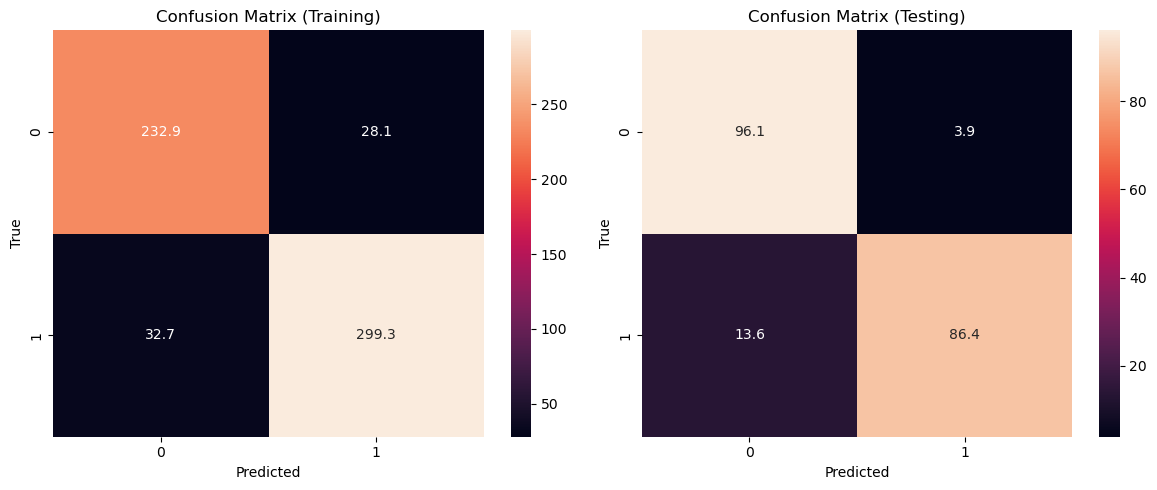

In [9]:


results_train = []
results_test = []
conf_mat_train = []
conf_mat_test = []
weights_list = []

for i in range(10): 
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_imbalanced, y_train_imbalanced, epochs=100, verbose=0)

    # Save the weights
    weights = model.get_weights()
    weights_list.append(weights)

    # Evaluate the model
    train_acc = history.history['accuracy']
    test_acc = model.evaluate(X_test_small, y_test_small, verbose=0)[1]

    # Save the results
    results_train.append(train_acc)
    results_test.append(test_acc)

    # Confusion matrices
    y_pred_train = (model.predict(X_train_imbalanced) > 0.5).astype(int)
    y_pred_test = (model.predict(X_test_small) > 0.5).astype(int)

    conf_mat_train.append(confusion_matrix(y_train_imbalanced, y_pred_train))
    conf_mat_test.append(confusion_matrix(y_test_small, y_pred_test))

# Calculate the mean results
mean_results_train = np.mean(results_train, axis=0)
mean_results_test = np.mean(results_test)

# Plot the results
plt.plot(np.log(range(1, 101)), mean_results_train, label="Train")
plt.plot(np.log(range(1, 101)), [mean_results_test] * 100, label="Test")
plt.xlabel("log(number of epochs)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Calculate mean confusion matrices
mean_conf_mat_train = np.mean(conf_mat_train, axis=0)
mean_conf_mat_test = np.mean(conf_mat_test, axis=0)

# Create a figure with two subplots, side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # Adjust the figsize as needed

# Plot the training confusion matrix
sns.heatmap(mean_conf_mat_train, annot=True, fmt="g", ax=ax[0])
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")
ax[0].set_title("Confusion Matrix (Training)")

# Plot the testing confusion matrix
sns.heatmap(mean_conf_mat_test, annot=True, fmt="g", ax=ax[1])
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")
ax[1].set_title("Confusion Matrix (Testing)")

# Display the plots
plt.tight_layout() # Adjust the layout to make sure everything fits without overlap
plt.show()

# Saving weights
# Assuming weights_list is defined elsewhere
file = open('weights.txt', 'w')
file.write(str(weights_list))
file.close()

7/7 [==============================] - 0s 308us/step


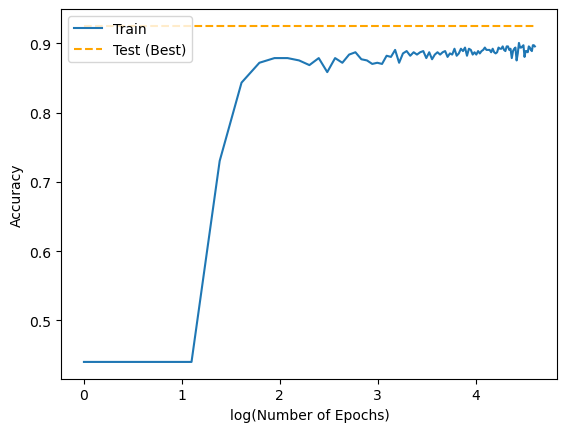

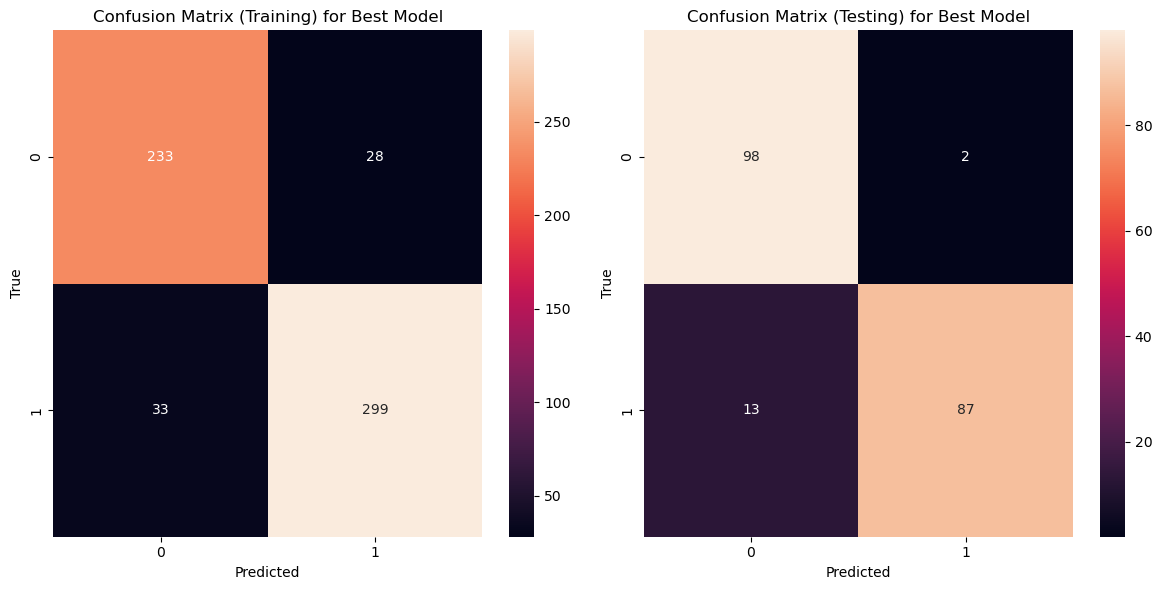

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

best_test_acc = 0  # Initialize the best test accuracy
best_model = None  # Placeholder for the best model
best_weights = None  # Placeholder for the best model's weights
best_epoch_acc = None  # Placeholder for the best model's epoch accuracy
best_conf_mat_train = None  # Placeholder for the best model's training confusion matrix
best_conf_mat_test = None  # Placeholder for the best model's testing confusion matrix

for i in range(1):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_imbalanced, y_train_imbalanced, epochs=100, verbose=0)

    # Evaluate the model
    test_acc = model.evaluate(X_test_small, y_test_small, verbose=0)[1]

    # Update the best model if the current one is better
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model = model
        best_weights = model.get_weights()
        best_epoch_acc = history.history['accuracy']
        
        # Confusion matrices for the best model
        y_pred_train = (model.predict(X_train_imbalanced) > 0.5).astype(int)
        y_pred_test = (model.predict(X_test_small) > 0.5).astype(int)
        best_conf_mat_train = confusion_matrix(y_train_imbalanced, y_pred_train)
        best_conf_mat_test = confusion_matrix(y_test_small, y_pred_test)

# Plot the results for the best model
plt.plot(np.log(range(1, 101)), best_epoch_acc, label="Train")
plt.hlines(best_test_acc, xmin=0, xmax=np.log(100), colors='orange', linestyles='dashed', label="Test (Best)")
plt.xlabel("log(Number of Epochs)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot training confusion matrix
sns.heatmap(best_conf_mat_train, annot=True, fmt="g", ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Confusion Matrix (Training) for Best Model")

# Plot testing confusion matrix
sns.heatmap(best_conf_mat_test, annot=True, fmt="g", ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Confusion Matrix (Testing) for Best Model")

plt.tight_layout()
plt.show()

# Code for saving weights remains the same
with open('weights_best_model.txt', 'w') as file:
    file.write(str(best_weights))

In [14]:
import numpy as np
import pyswarms as ps
import tensorflow as tf

input_dim = X_train_imbalanced.shape[1]  # Number of features

# Define the neural network architecture and fitness function
def fitness_function(weights):
    num_particles = weights.shape[0]
    accuracies = []

    for i in range(num_particles):
        # Reshape the particle weights into the format of the neural network weights
        w_layer1 = weights[i, :input_dim*20].reshape(input_dim, 20)
        b_layer1 = weights[i, input_dim*20:(input_dim+1)*20].reshape(20)
        w_layer2 = weights[i, (input_dim+1)*20:-1].reshape(20, 1)
        b_layer2 = weights[i, -1].reshape(1)

        # Create the model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(20, input_dim=input_dim, activation='sigmoid', weights=[w_layer1, b_layer1]),
            tf.keras.layers.Dense(1, activation='sigmoid', weights=[w_layer2, b_layer2])
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Fit the model (dummy fitting as weights are already set)
        model.fit(X_train_imbalanced, y_train_imbalanced, epochs=1, batch_size=32, verbose=0)
        
        # Evaluate the model
        _, accuracy = model.evaluate(X_test_small, y_test_small, verbose=0)
        accuracies.append(-accuracy)  # Negative accuracy for minimization

    return np.array(accuracies)

# Set up PSO
options = {'c1': 1.7, 'c2': 1.3, 'w':0.4}  # cognitive parameter, social parameter, inertia weight
dimensions = (input_dim + 1) * 20 + 21  # Total number of weights and biases in the network

# Create a bounds matrix with shape (2, dimensions)
# where `ub` and `lb` are the upper and lower bounds respectively
max_bound = np.ones(dimensions)
min_bound = -max_bound
bounds = (min_bound, max_bound)

# Initialize the swarm
optimizer = ps.single.GlobalBestPSO(n_particles=30, dimensions=dimensions, options=options, bounds=bounds)

# Perform optimization
cost, pos = optimizer.optimize(fitness_function, iters=100)

# Use the best found position (pos) as the optimal weights for the network


2024-04-21 19:51:51,850 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.7, 'c2': 1.3, 'w': 0.4}
pyswarms.single.global_best: 100%|█████████████████████|100/100, best_cost=-.935
2024-04-21 20:02:09,194 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9350000023841858, best pos: [-7.80683266e-01  5.12905624e-02  2.98696314e-02  1.86920850e-01
  1.20483058e-01 -1.78531235e-01 -5.88033958e-01  6.27414272e-01
 -3.05068311e-02  7.45506303e-04  4.02222426e-01 -5.06209932e-01
 -8.20587580e-01 -3.79411475e-01  5.87534529e-01  8.18001332e-01
  1.68809633e-02  1.91104873e-01  6.42125644e-01 -7.76241628e-02
  1.95996259e-01 -7.64071569e-01 -1.96902694e-02 -1.75112044e-02
 -2.22030546e-01 -3.22262636e-01 -2.89990922e-01  7.47295726e-01
 -3.55207105e-01 -5.41154130e-01 -7.52113596e-01 -1.77875627e-01
  8.32070812e-01 -1.42021738e-03 -5.40638529e-01  1.60633561e-01
 -6.52256350e-01 -3.15494214e-01  1.79087925e-01  4.38179520e-01
 -1.95634180e-01

7/7 [==============================] - 0s 403us/step


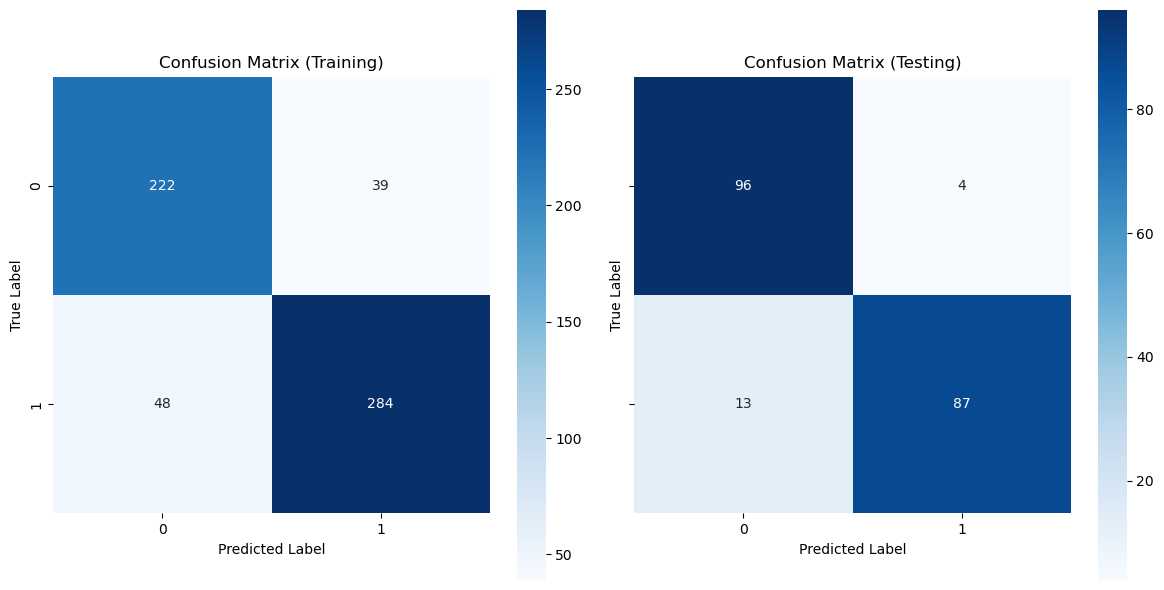

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

input_dim = X_train_imbalanced.shape[1]  # Number of input features

# Rebuild the model with optimal weights
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_dim=input_dim, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Update model with the optimal weights
w_layer1 = pos[:input_dim*20].reshape(input_dim, 20)
b_layer1 = pos[input_dim*20:(input_dim+1)*20].reshape(20)
w_layer2 = pos[(input_dim+1)*20:-1].reshape(20, 1)
b_layer2 = pos[-1].reshape(1)
model.set_weights([w_layer1, b_layer1, w_layer2, b_layer2])

# Predict for both training and testing datasets
y_pred_train = (model.predict(X_train_imbalanced) > 0.5).astype(int)
y_pred_test = (model.predict(X_test_small) > 0.5).astype(int)

# Compute confusion matrices
conf_mat_train = confusion_matrix(y_train_imbalanced, y_pred_train.flatten())
conf_mat_test = confusion_matrix(y_test_small, y_pred_test.flatten())

# Visualization of the confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
sns.heatmap(conf_mat_train, annot=True, fmt="d", ax=axes[0], cmap='Blues', square=True)
axes[0].set_title("Confusion Matrix (Training)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(conf_mat_test, annot=True, fmt="d", ax=axes[1], cmap='Blues', square=True)
axes[1].set_title("Confusion Matrix (Testing)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()
